# Reflection in Hot Jupiters 

This tutorial covers how albedo and reflection spectra are computed in POSEIDON v1.2.

The calculation of reflection spectra inherently requires one to account for directional scattering. The scattering can arise from various processes, including Rayleigh scattering (which is symmetric) and scattering from aerosols (which can have strong back-scattering cross sections). Consequently, we recommend first going through the previous tutorials [\"Generating Secondary Eclipse Emission Spectra\"](emission_basic.html), [\"Clouds In Transmission Spectra\"](transmission_clouds.html), and [\"Thermal Scattering\"](emission_scattering.html).

For background reading on exoplanet albedo / reflection spectra, be sure to check out [Sudarsky 2000](https://ui.adsabs.harvard.edu/abs/2000ApJ...538..885S/abstract).

For this notebook, we will see how reflection affects the secondary eclipse spectrum of a hot Jupiter. 

## Reflection Spectroscopy in POSEIDON

POSEIDON v1.2 includes reflection spectroscopy modelling capabilities adapted from the [PICASO](https://natashabatalha.github.io/picaso/) package developed by Natasha Batalha. If you use POSEIDON for reflection spectroscopy, please cite [Batalha et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...878...70B/abstract) to recognise the significant work of the PICASO team in developing the reflection forward model used in POSEIDON.

Note that the PICASO is *not* a modular dependency of POSEIDON, rather several radiative transfer functions from PICASO have been adapted to work within the internal structure of POSEIDON.

<div class="alert alert-info">

  **Note:**

  If you downloaded the aerosol database hdf5 file for v1.2, you will need to download the new version released with v1.3.1, which has updated, more accurate aerosol scattering properties. You can find the updated aerosol database on [Zenodo](https://doi.org/10.5281/zenodo.15711943).

</div>

## Example: HD 189733b Secondary Eclipse

Here we use HD 189733b as a test case. We define a clear model with no reflection, a clear model with reflection, and a model with MgSiO3 (enstatite) aerosols (slab model, patchy).

Hot Jupiter eclipse spectra at visible wavelengths can be either dark (due to alkali absorption) or bright (due to reflected light from silicate clouds.

For reflection, there are a few things to be noted. 

1. The user must include the planet's distance from it's host star into the create_planet() function via a_p = 'distance from host star'
2. Below, we define the wavelength grid to be linear from 0.2 to 1 um. This is because reflection uses a tridiagonal matrix solver that can be slow, and wavenumber resolution can crowd the UVIS wavelengths with points. 
3. When we define our model, we introduce three new options 
- reflection = True (turns on reflection)
- Na_K_fixed_ratio = True (this just makes it to where log_K = 0.1 log_Na)
- reflection_up_to_5um = True (computed albedo only up to 5 um, to speed up calculations)

In [1]:
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.core import create_star, create_planet, define_model, \
                          wl_grid_constant_R, read_opacities

import numpy as np
from scipy.constants import au
from scipy.constants import parsec as pc

#***** Model wavelength grid *****#

wl_min = 0.2     # Minimum wavelength (um)
wl_max = 5     # Maximum wavelength (um)
R = 5000         # Spectral resolution of grid

# We need to provide a model wavelength grid to initialise instrument properties
wl_1 = np.linspace(wl_min, 1.0, 1000)[:-1]
wl_2 = wl_grid_constant_R(1.0, wl_max, R)
wl_2 = wl_2[1:]    # Indexing to avoid 1.0 um being repeated twice
wl = np.concatenate((wl_1, wl_2))

#***** Define planet properties *****#

planet_name = 'HD 189733b'  # Planet name used for plots, output files etc.

R_p = 1.13*R_J    # Planetary radius (m)
M_p = 1.129*M_J
d = 19.7638*pc
a_p = 0.03142*au

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, a_p = a_p)


#***** Define stellar properties *****#

R_s = 0.78*R_Sun   # Stellar radius (m)
T_s = 5014         # Stellar effective temperature (K)
Met_s = 0.13       # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.58     # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

#***** Define model *****#

model_name_clear_no_reflect = 'No_Reflection'

#***** Define model *****#

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2', 'H2O', 'K','Na',]

# Create the model object
model_clear_no_reflect = define_model(model_name_clear_no_reflect, bulk_species, param_species, 
                                      PT_profile = 'Guillot_dayside',
                                      scattering = False, reflection = False, 
                                      Na_K_fixed_ratio = True,
                                      reflection_up_to_5um = True)

model_name_clear_reflect = 'Reflection'

#***** Define model *****#

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2', 'H2O', 'K','Na',]

# Create the model object
model_clear_reflect = define_model(model_name_clear_reflect, bulk_species, param_species, 
                                   PT_profile = 'Guillot_dayside',
                                   scattering = True, reflection = True, 
                                   Na_K_fixed_ratio = True,
                                   reflection_up_to_5um = True)


model_name_MgSiO3_reflect = 'HD189-ER-MgSiO3-Patchy-New-Alkalis'

#***** Define model *****#

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2', 'H2O', 'K','Na',]
aerosol_species = ['MgSiO3']

# Create the model object
model_MgSiO3_reflect = define_model(model_name_MgSiO3_reflect, bulk_species, param_species, 
                                    PT_profile = 'Guillot_dayside',
                                    cloud_model = 'Mie',cloud_type = 'slab',
                                    aerosol_species = aerosol_species,
                                    scattering = True, reflection = True, 
                                    Na_K_fixed_ratio = True,
                                    reflection_up_to_5um = True,
                                    cloud_dim = 2)



Now we load in the cross sections.

In [16]:
#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100     # Same as prior range for T
T_fine_max = 3000    # Same as prior range for T
T_fine_step = 20     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-6   # 1 ubar
P_max = 100      # 100 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # Retrieved R_p_ref parameter will be the radius at 1 bar

#***** Run atmospheric retrieval *****#
print('Loading in opac for clear models')
opac_clear = read_opacities(model_clear_reflect, wl, opacity_treatment, T_fine, log_P_fine)

# Create opac object with MgSiO3 aerosols 
# This funciton takes the clear opac object and adds MgSiO3 aerosols 
# Skipping the gas-opacity pre-interpolation 
# Note that you can also just use the read_opacities function again to make opac object with 
# MgSiO3 aerosols

from POSEIDON.clouds import switch_aerosol_in_opac
print()
print('Loading in opac with MgSiO3 aerosols')
opac_mgsio3 = switch_aerosol_in_opac(model_MgSiO3_reflect,opac_clear)

Loading in opac for clear models
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
CO2-H2 done
CO2-CO2 done
CO done
CO2 done
H2O done
Na done
K done
Opacity pre-interpolation complete.

Loading in opac with MgSiO3 aerosols
Reading in database for aerosol cross sections...


For now, lets just assume some cloud properties (slab near the thermal inversion). We will explore different cloud properties later on in the notebook.

Also, lets define an atmosphere with negligible alkali abundance, to see how alkalis shape reflection.

Lets also put a slab high up in the atmosphere, where the slab is higher up in the atmosphere (lower pressures).

In [3]:
from POSEIDON.core import make_atmosphere

R_p_ref               =   1.12 * R_J

log_kappa_IR          =   -4.82 
log_gamma             =   -0.42 
T_int                 =   255.7 
T_equ                 =   1159.5

log_CO                =   -5.30 
log_CO2               =   -3.07 
log_H2O               =   -5.33  
log_Na                =   -6.59 


f_cloud               =   1
log_P_top_slab_MgSiO3 =   -1
Delta_log_P_MgSiO3    =   3
log_r_m_MgSiO3        =   -1.40
log_X_MgSiO3          =   -15

PT_params = np.array([log_kappa_IR, log_gamma, T_int, T_equ])

log_X_params = np.array([log_CO, log_CO2, log_H2O, log_Na,])

cloud_params = np.array([f_cloud, log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])


atmosphere_clear_no_reflect = make_atmosphere(planet, model_clear_no_reflect, P, P_ref, R_p_ref, 
                                              PT_params, log_X_params)

atmosphere_clear_reflect = make_atmosphere(planet, model_clear_reflect, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params)

atmosphere_MgSiO3_reflect = make_atmosphere(planet, model_MgSiO3_reflect, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

# With no alkalis 

log_X_params = np.array([log_CO, log_CO2, log_H2O, -50,])

atmosphere_clear_reflect_no_alkalis = make_atmosphere(planet, model_clear_reflect, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params)

# MgSiO3 high up in atmosphere 

log_X_params = np.array([log_CO, log_CO2, log_H2O, log_Na,])
cloud_params = np.array([f_cloud, -6, Delta_log_P_MgSiO3, log_r_m_MgSiO3, -10])

atmosphere_MgSiO3_reflect_high_up = make_atmosphere(planet, model_MgSiO3_reflect, P, P_ref, R_p_ref, 
                                            PT_params, log_X_params, cloud_params)

Let's see what the atmosphere looks like.

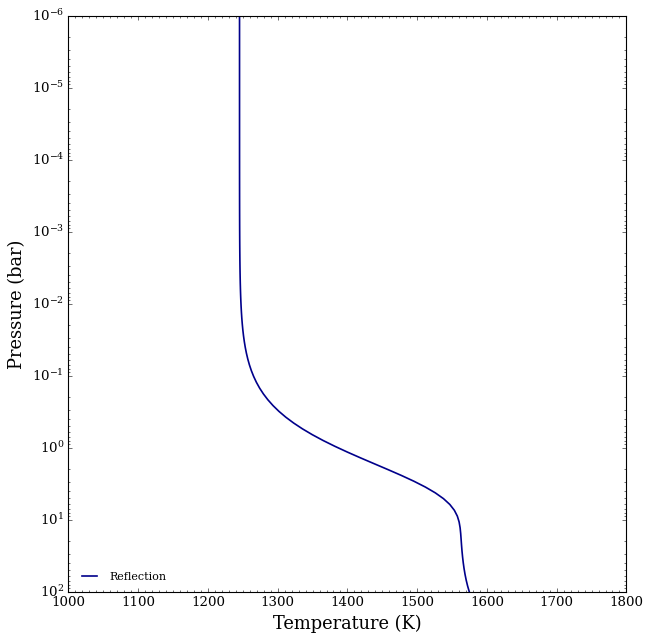

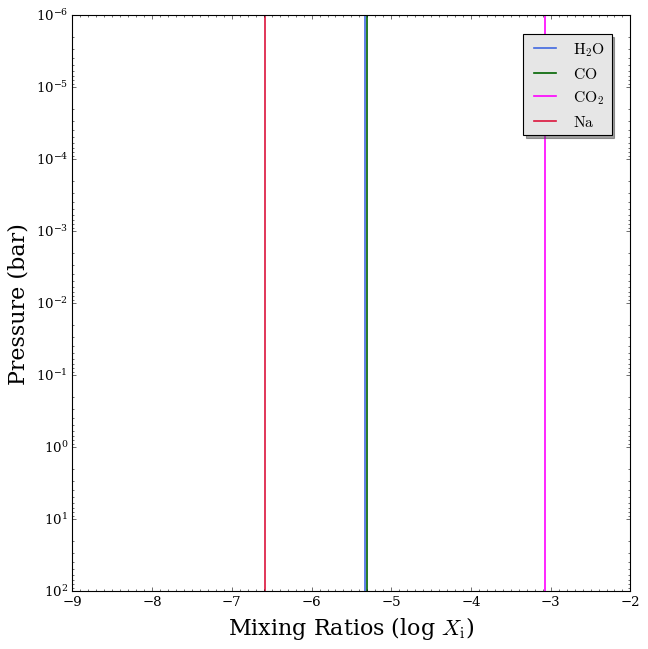

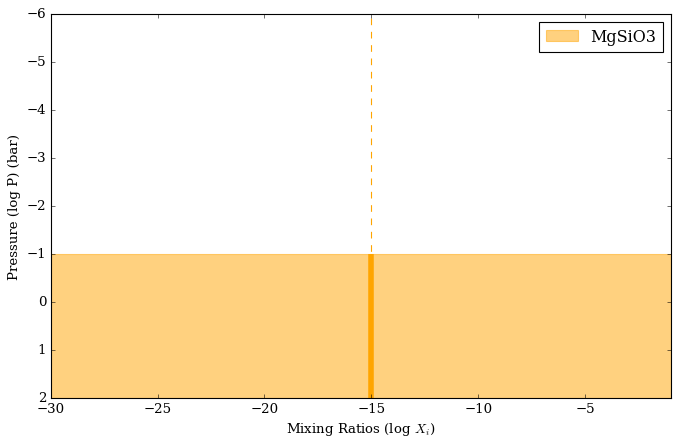

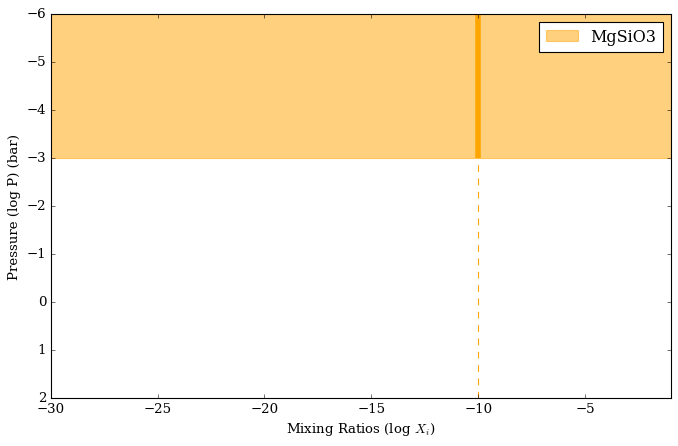

In [4]:
from POSEIDON.visuals import plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_clear_reflect, atmosphere_clear_reflect, log_P_max = 2.0)


fig_chem = plot_chem(planet, model_clear_reflect, atmosphere_clear_reflect, 
                     plot_species = ['H2O', 'CO', 'CO2', 'Na'],
                     log_X_min = -9, log_P_max = 2.0)


from POSEIDON.clouds import plot_clouds

plot_clouds(planet,model_MgSiO3_reflect,atmosphere_MgSiO3_reflect)

plot_clouds(planet,model_MgSiO3_reflect,atmosphere_MgSiO3_reflect_high_up)

Now let's compute some spectra! 

When computing spectra with reflection turned on, there's also an option to turn on 'return_albedo', which will return the geometric albedo computed by the reflection function. 

In [5]:
from POSEIDON.core import compute_spectrum

Fp_Fs_clear_no_reflect = compute_spectrum(planet, star, model_clear_no_reflect, atmosphere_clear_no_reflect, opac_clear, wl, 
                                          spectrum_type = 'emission') 

Fp_Fs_clear_reflect, \
albedo_clear = compute_spectrum(planet, star, model_clear_reflect, atmosphere_clear_reflect, opac_clear, wl, 
                                spectrum_type = 'emission', return_albedo = True) 

Fp_Fs_clear_reflect_no_alkalis, \
albedo_clear_no_alkalis = compute_spectrum(planet, star, model_clear_reflect, atmosphere_clear_reflect_no_alkalis, opac_clear, wl, 
                                           spectrum_type = 'emission', return_albedo = True) 

Fp_Fs_MgSiO3_reflect, \
albedo_MgSiO3 = compute_spectrum(planet, star, model_MgSiO3_reflect, atmosphere_MgSiO3_reflect, opac_mgsio3, wl, 
                                 spectrum_type = 'emission', return_albedo = True) 

Fp_Fs_MgSiO3_reflect_high_up, \
albedo_MgSiO3_high_up = compute_spectrum(planet, star, model_MgSiO3_reflect, atmosphere_MgSiO3_reflect_high_up, opac_mgsio3, wl, 
                                         spectrum_type = 'emission', return_albedo = True) 

Generate the plots.

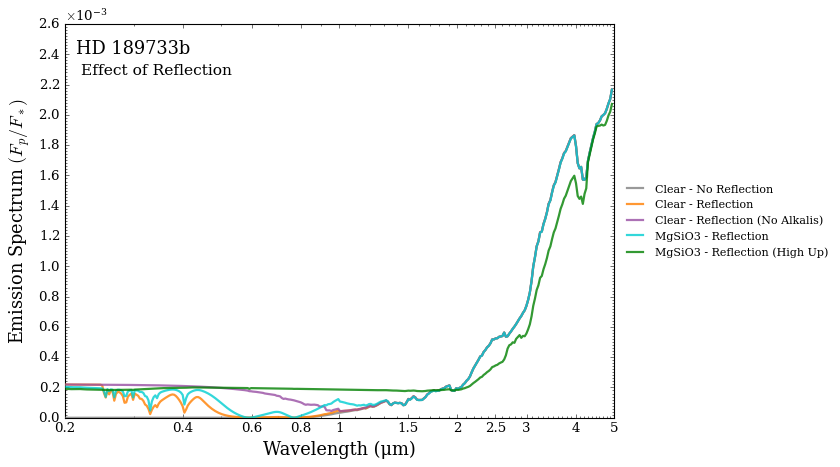

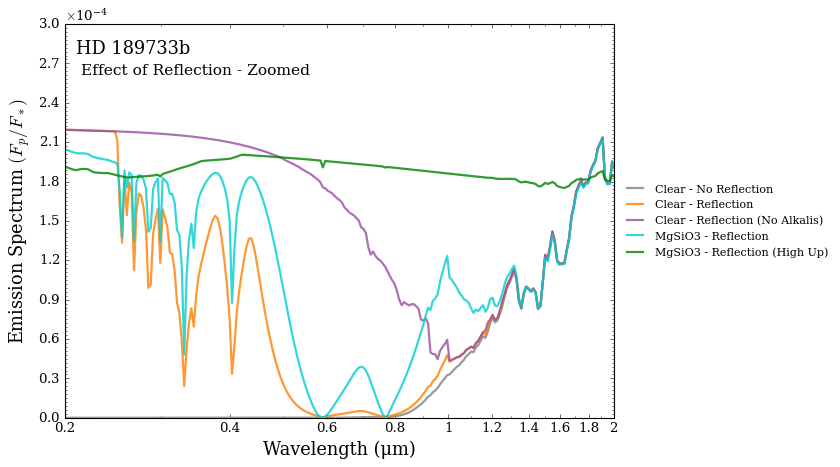

In [6]:
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

spectra = []

# Add the three model spectra to the plot collection object
spectra = plot_collection(Fp_Fs_clear_no_reflect, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_clear_reflect, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_clear_reflect_no_alkalis, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_MgSiO3_reflect, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_MgSiO3_reflect_high_up, wl, collection = spectra)

# Plot spectra
title = 'Effect of Reflection'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', 
                        spectra_labels = ['Clear - No Reflection', 'Clear - Reflection', 
                                          'Clear - Reflection (No Alkalis)', 'MgSiO3 - Reflection',
                                          'MgSiO3 - Reflection (High Up)'],
                        legend_location = 'outside right', wl_axis = 'log', 
                        colour_list = ['gray', '#ff7f00', '#984ea3', 'darkturquoise', 'green'],
                        plt_label = title,
                        figure_shape = 'wide')

# Produce figure and save to file
title = 'Effect of Reflection - Zoomed'

fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', 
                        spectra_labels = ['Clear - No Reflection', 'Clear - Reflection',
                                          'Clear - Reflection (No Alkalis)', 'MgSiO3 - Reflection', 
                                          'MgSiO3 - Reflection (High Up)'],
                        legend_location = 'outside right', wl_axis = 'log', 
                        colour_list = ['gray', '#ff7f00', '#984ea3', 'darkturquoise', 'green'],
                        plt_label = title,
                        figure_shape = 'wide',
                        wl_max = 2, y_max = 0.3e-3)

From above we can make a few observations:

1. With no alkalis, the planet is brightest due to reflection (purple line). This is solely due to Rayleigh reflection. 
2. However, with equilibrium chemistry we expect hot Jupiters to have alkali abundances, which substantially darken spectra (orange line)
3. Silicate clouds can form in hot Jupiters, and can back scatter light (blue line). It also has a reflection spike near 1 um.
4. When silicates are deep in the atmosphere, the alkali absorption imprints on the spectra still (imagine that the starlight has to go through the atmosphere with alkalis, all the way down to the slab, and then reflect back out). When the silicates are high up, they can reflect the star-light before alkalis imprint on the spectra.

After about 1.5 microns, the reflection signal is washed out by the emission signal (where H2O absorption features start to show up). However, this is not always the case (see Parameter Exploration below)

Now let's plot the albedos. To make them easier to plot up, we bin the spectra down first.

POSEIDON returns the planet-star flux ratio by default, but as we saw above the `compute_spectrum` function can also return the geometric albedo spectrum. These quantities are related by the following equation

$$
\begin{equation}
F_{\rm{p, \, reflected, \, obs}}(\lambda) = A_g(\lambda) \; \left(\frac{R_p(\lambda)}{a_p}\right)^2 \;  \left(\frac{R_s}{d}\right)^2 \; F_s(\lambda)
\end{equation}
$$

Let's plot the geometric albedo spectra from the models above:

(0.2, 2.0)

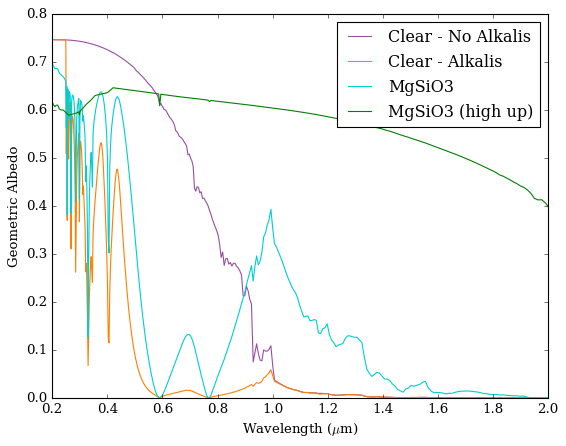

In [7]:
from POSEIDON.utility import bin_spectrum
import matplotlib.pyplot as plt 

wl_binned, spectrum_binned, err_binned = bin_spectrum(wl, albedo_clear_no_alkalis, 150, err_data = [])
plt.plot(wl_binned, spectrum_binned, label = 'Clear - No Alkalis', c = '#984ea3')

wl_binned, spectrum_binned, err_binned = bin_spectrum(wl, albedo_clear, 150, err_data = [])
plt.plot(wl_binned, spectrum_binned, label = 'Clear - Alkalis', c = '#ff7f00')

wl_binned, spectrum_binned, err_binned = bin_spectrum(wl, albedo_MgSiO3, 150, err_data = [])
plt.plot(wl_binned, spectrum_binned, label = 'MgSiO3', c = 'darkturquoise')

wl_binned, spectrum_binned, err_binned = bin_spectrum(wl, albedo_MgSiO3_high_up, 150, err_data = [])
plt.plot(wl_binned, spectrum_binned, label = 'MgSiO3 (high up)', c = 'green')

plt.ylabel('Geometric Albedo')
plt.xlabel('Wavelength ($\mu$m)')
plt.legend()
plt.xlim((0.2,2))

## Reflection Parameter Exploration

Let's shorten the wavelength array to just focus on the 0.2 to 2 um region.

Since the wavelength array has changed, we reinitialise the opacities and recreate the star object. 

In [8]:
wl_min = 0.2     # Minimum wavelength (um)
wl_max = 2     # Maximum wavelength (um)
R = 5000         # Spectral resolution of grid

# We need to provide a model wavelength grid to initialise instrument properties
wl_1 = np.linspace(wl_min, 1.0, 1000)[:-1]
wl_2 = wl_grid_constant_R(1.0, wl_max, R)
wl_2 = wl_2[1:]    # Indexing to avoid 1.0 um being repeated twice
wl = np.concatenate((wl_1, wl_2))

# Can also just load in aerosols in normal function
opac_mgsio3 = read_opacities(model_MgSiO3_reflect, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
CO2-H2 done
CO2-CO2 done
CO done
CO2 done
H2O done
Na done
K done
Reading in database for aerosol cross sections...
Opacity pre-interpolation complete.


In [9]:
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

In [10]:
R_p_ref               =   1.12 * R_J

log_kappa_IR          =   -4.82 
log_gamma             =   -0.42 
T_int                 =   255.7 
T_equ                 =   1159.5

log_CO                =   -5.30 
log_CO2               =   -3.07 
log_H2O               =   -5.33  
log_Na                =   -6.59 


f_cloud               =   1
log_P_top_slab_MgSiO3 =   -1
Delta_log_P_MgSiO3    =   3
log_r_m_MgSiO3        =   -1.40
log_X_MgSiO3          =   -15

PT_params = np.array([log_kappa_IR, log_gamma, T_int, T_equ])

log_X_params = np.array([log_CO, log_CO2, log_H2O, log_Na,])

cloud_params = np.array([f_cloud, log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])

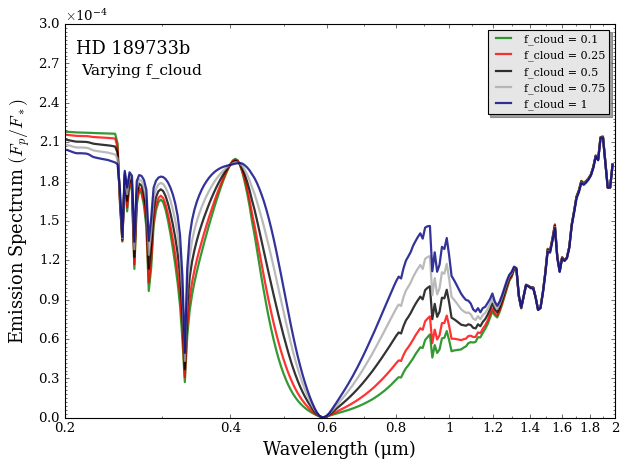

In [12]:
from POSEIDON.clouds import vary_one_parameter

param_name = 'f_cloud'
vary_list = [0.1, 0.25, 0.5, 0.75, 1]


vary_one_parameter(model_MgSiO3_reflect, planet, star, param_name, vary_list,
                   wl, opac_mgsio3, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                   spectrum_type = 'emission', y_unit = 'Fp/Fs')

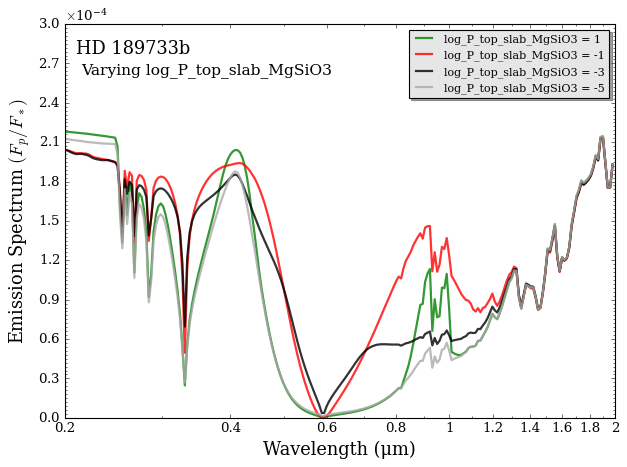

In [13]:
from POSEIDON.clouds import vary_one_parameter

param_name = 'log_P_top_slab_MgSiO3'
vary_list = [1,-1,-3,-5]

vary_one_parameter(model_MgSiO3_reflect, planet, star, param_name, vary_list,
                   wl, opac_mgsio3, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                   spectrum_type = 'emission', y_unit = 'Fp/Fs')

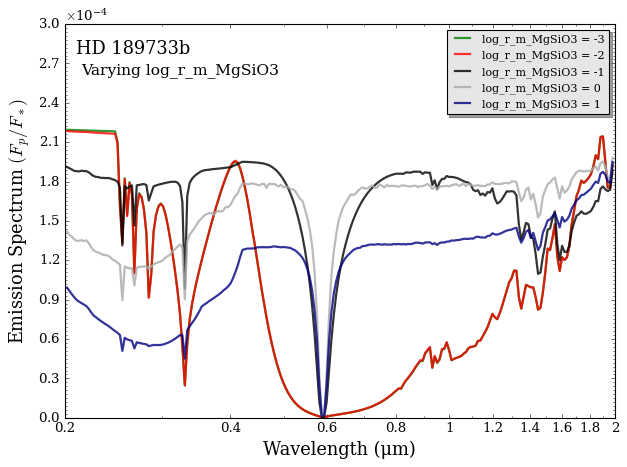

In [14]:
from POSEIDON.clouds import vary_one_parameter

param_name = 'log_r_m_MgSiO3'
vary_list = [-3,-2,-1,0,1]

vary_one_parameter(model_MgSiO3_reflect, planet, star, param_name, vary_list,
                   wl, opac_mgsio3, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                   spectrum_type = 'emission', y_unit = 'Fp/Fs')

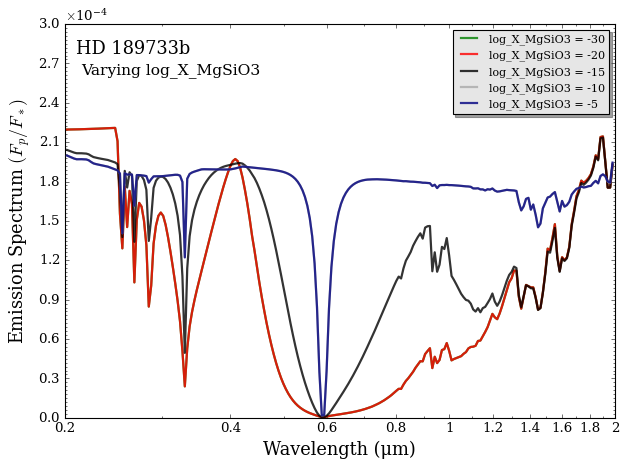

In [15]:
from POSEIDON.clouds import vary_one_parameter

param_name = 'log_X_MgSiO3'
vary_list = [-30, -20, -15, -10, -5]

vary_one_parameter(model_MgSiO3_reflect, planet, star, param_name, vary_list,
                   wl, opac_mgsio3, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params,
                   spectrum_type = 'emission', y_unit = 'Fp/Fs')